# 라이브러리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !set -x \
# && pip install konlpy \
# && curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x
!pip install soynlp
!pip install wordcloud
!pip install pyLDAvis==2.1.2
!pip install pmdarima

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 12, 12   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = r"/content/drive/MyDrive/3조_final_project/98_코딩파일/NanumBarunGothic.ttf"
font = fm.FontProperties(fname=fontpath, size=14)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [43]:
import numpy as np
import pandas as pd

from wordcloud import WordCloud
from IPython.display import Image

from collections import Counter

# 경고문 무시
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk import word_tokenize, bigrams, ConditionalFreqDist
from nltk.util import ngrams
from nltk.probability import ConditionalProbDist, MLEProbDist
# from konlpy.tag import Okt, Hannanum, Kkma, Komoran, Mecab
import soynlp
from soynlp.noun import LRNounExtractor_v2
from soynlp.tokenizer import LTokenizer

from gensim import corpora
from gensim.models import LsiModel, LdaModel, Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import pyLDAvis.gensim

# 파일 합치기
import glob
import sys
import os

# 기타
import re
import requests
import json
import time
from google.colab import drive
from tqdm import notebook

# 0 전처리

## 데이터 로드
- 5대일간지 (조선일보, 중앙일보, 동아일보, 한겨레, 경향신문)
- https://www.bigkinds.or.kr/

In [5]:
df = pd.read_csv(r'/content/drive/MyDrive/3조_final_project/01_뉴스 기사/5대일간지_20201101-20211231.csv')

In [6]:
# 사용할 컬럼 선택
df = df[['일자','언론사','제목']]

In [7]:
# 사용할 일자 선택 => 2021년
df['일자']=pd.to_datetime(df['일자'], errors='coerce', format='%Y%m%d')
df.dropna(inplace=True)
df = df[(df['일자'] >= '2021-01-01') & (df['일자'] < '2022-01-01')]

In [8]:
# 달 분리
df.insert(loc=1,column='month',value=df['일자'].dt.month)

print(len(df.일자.unique()))
print(len(df.month.unique()))

365
12


In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df.head()

,일자,month,언론사,제목
0,2021-01-31,1,경향신문,"“푸틴은 도둑놈” 러시아 2주 연속 나발니 석방 시위, 2000여명 체포"
1,2021-01-31,1,경향신문,‘YS 42년간 보좌’ 이원종 전 정무수석 별세
2,2021-01-31,1,경향신문,손동우 전 한국언론진흥재단 경영본부장 별세
3,2021-01-31,1,경향신문,승객이 택시에 두고 내린 가방서 마약 발견돼 경찰 수사
4,2021-01-31,1,경향신문,재보선 전초전 ‘2월 입법전쟁’ 본격화 ‘법관탄핵 대북원전’ 공방 예고


In [11]:
df.shape

(347032, 4)

In [12]:
df.isna().sum()

일자       0
month    0
언론사      0
제목       0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347032 entries, 0 to 347031
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   일자      347032 non-null  datetime64[ns]
 1   month   347032 non-null  int64         
 2   언론사     347032 non-null  object        
 3   제목      347032 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 10.6+ MB


## 단어 추출 (soynlp)
- https://github.com/lovit/soynlp

In [14]:
df['제목'] = df['제목'].str.replace("[^a-zA-Zㄱ-ㅣ가-힣 ]"," ")

In [15]:
# 형태소 분석기
noun_extractor = LRNounExtractor_v2()
nouns = noun_extractor.train_extract(list(df['제목']))
noun_scores = {noun:score.score for noun, score in nouns.items()}
tokenizer = LTokenizer(scores=noun_scores)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 310539 from 347032 sents. mem=1.323 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=2724590, mem=1.760 Gb
[Noun Extractor] batch prediction was completed for 69100 words
[Noun Extractor] checked compounds. discovered 53390 compounds
[Noun Extractor] postprocessing detaching_features : 67210 -> 59349
[Noun Extractor] postprocessing ignore_features : 59349 -> 59180
[Noun Extractor] postprocessing ignore_NJ : 59180 -> 58775
[Noun Extractor] 58775 nouns (53390 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=1.836 Gb                    
[Noun Extractor] 74.40 % eojeols are covered


In [16]:
df['soynlp_nouns'] = df['제목'].apply(lambda x : tokenizer.tokenize(x))

In [17]:
df.head()

,일자,month,언론사,제목,soynlp_nouns
0,2021-01-31,1,경향신문,푸틴은 도둑놈 러시아 주 연속 나발니 석방 시위 여명 체포,"[푸틴, 은, 도둑, 놈, 러시아, 주, 연속, 나발, 니, 석방, 시위, 여명, 체포]"
1,2021-01-31,1,경향신문,YS 년간 보좌 이원종 전 정무수석 별세,"[YS, 년간, 보좌, 이원종, 전, 정무수석, 별세]"
2,2021-01-31,1,경향신문,손동우 전 한국언론진흥재단 경영본부장 별세,"[손동우, 전, 한국언론진흥재단, 경영본부장, 별세]"
3,2021-01-31,1,경향신문,승객이 택시에 두고 내린 가방서 마약 발견돼 경찰 수사,"[승객, 이, 택시, 에, 두고, 내린, 가방, 서, 마약, 발견, 돼, 경찰, 수사]"
4,2021-01-31,1,경향신문,재보선 전초전 월 입법전쟁 본격화 법관탄핵 대북원전 공방 예고,"[재보선, 전초, 전, 월, 입법, 전쟁, 본격화, 법관, 탄핵, 대북원, 전, 공..."


## 단어 변경
- https://datascienceschool.net/03%20machine%20learning/03.01.04%20soynlp.html

In [18]:
def noun_replace(data) :
  data = data.replace('美','미국')
  data = data.replace('文' ,'대통령')
  data = data.replace('中','중국')
  data = data.replace('與','여당')
  data = data.replace('日', '일본')
  data = data.replace('野','야당')
  data = data.replace('靑','청와대')
  data = data.replace('北','북한')
  data = data.replace('英','영국')
  data = data.replace('韓','한국')
  data = data.replace('男','남성')
  data = data.replace('女','여성')

  data = data.replace('李','이재명')
  data = data.replace('尹','윤석열')

  data = data.replace('두기', '거리두기')
  data = data.replace('의힘', '국민의힘')

  return data

In [19]:
df['soynlp_nouns'] = df['soynlp_nouns'].apply(lambda x : [noun_replace(word) for word in x])

## 불용어(StopWords) 처리
- https://www.ranks.nl/stopwords/korean

In [20]:
# 파일 불러오기
stop_words = pd.read_csv(r'/content/drive/MyDrive/3조_final_project/01_뉴스 기사/stop_words_news.txt', sep='\n', encoding='utf8', header=None)

# set으로 중복 제거 후 리스트로 변환
stop_words = list(set(stop_words[0]))
print(len(stop_words))

1186


In [21]:
df['noun'] = df['soynlp_nouns'].apply(lambda x : [word for word in x if word not in stop_words])
df.head(10)

,일자,month,언론사,제목,soynlp_nouns,noun
0,2021-01-31,1,경향신문,푸틴은 도둑놈 러시아 주 연속 나발니 석방 시위 여명 체포,"[푸틴, 은, 도둑, 놈, 러시아, 주, 연속, 나발, 니, 석방, 시위, 여명, 체포]","[푸틴, 도둑, 놈, 러시아, 나발, 니, 석방, 시위, 여명, 체포]"
1,2021-01-31,1,경향신문,YS 년간 보좌 이원종 전 정무수석 별세,"[YS, 년간, 보좌, 이원종, 전, 정무수석, 별세]","[YS, 보좌, 이원종, 정무수석]"
2,2021-01-31,1,경향신문,손동우 전 한국언론진흥재단 경영본부장 별세,"[손동우, 전, 한국언론진흥재단, 경영본부장, 별세]","[손동우, 한국언론진흥재단, 경영본부장]"
3,2021-01-31,1,경향신문,승객이 택시에 두고 내린 가방서 마약 발견돼 경찰 수사,"[승객, 이, 택시, 에, 두고, 내린, 가방, 서, 마약, 발견, 돼, 경찰, 수사]","[승객, 택시, 두고, 내린, 가방, 마약]"
4,2021-01-31,1,경향신문,재보선 전초전 월 입법전쟁 본격화 법관탄핵 대북원전 공방 예고,"[재보선, 전초, 전, 월, 입법, 전쟁, 본격화, 법관, 탄핵, 대북원, 전, 공...","[재보선, 전초, 입법, 전쟁, 본격화, 법관, 탄핵, 대북원, 공방]"
5,2021-01-31,1,경향신문,오늘의 인사 년 월 일,"[오늘, 의, 인사, 년, 월, 일]",[]
6,2021-01-31,1,경향신문,오늘의 부고 년 월 일,"[오늘, 의, 부고, 년, 월, 일]",[]
7,2021-01-31,1,경향신문,SK하이닉스 이석희 사장 미국 IEEE 우수리더상 수상,"[SK, 하이닉스, 이석희, 사장, 미국, IEEE, 우수, 리더상, 수상]","[SK, 하이닉스, 이석희, 사장, 미국, IEEE, 우수, 리더상]"
8,2021-01-31,1,경향신문,TV하이라이트 년 월 일,"[TV, 하이라이트, 년, 월, 일]","[TV, 하이라이트]"
9,2021-01-31,1,경향신문,케이블 위성 하이라이트 년 월 일,"[케이블, 위성, 하이라이트, 년, 월, 일]","[케이블, 위성, 하이라이트]"


## 말뭉치(corpus) 만들기

In [22]:
# 전체 corpus
nouns = []
for i in range(len(df)) :
  nouns.append(df['noun'][i])

corpus = [y for x in nouns for y in x]

print(len(corpus))

2119240


In [23]:
# 월별 corpus
for i in range(1,13) :
  globals()['df_{}'.format(i)] = df[df.month == i]
  print(i, globals()['df_{}'.format(i)].shape, end=' ')
  a, b = globals()['df_{}'.format(i)].shape

  nouns = []
  for j in range(a) :
    nouns.append(globals()['df_{}'.format(i)]['noun'].iloc[j])

  globals()['corpus_{}'.format(i)] = [y for x in nouns for y in x]

  print(len(globals()['corpus_{}'.format(i)]))

1 (28728, 6) 169972
2 (24249, 6) 145851
3 (29154, 6) 175570
4 (28568, 6) 172961
5 (27293, 6) 164633
6 (28895, 6) 176252
7 (31148, 6) 191810
8 (28831, 6) 178605
9 (31478, 6) 196794
10 (28737, 6) 177543
11 (29694, 6) 183705
12 (30257, 6) 185544


# 1 전체 데이터 분석

## 1-1 단어 빈도 분석

In [24]:
# Counter
noun_count = Counter(corpus)

# 데이터 프레임으로
word_freq = pd.DataFrame(data=[noun_count.keys(), noun_count.values()])
word_freq = word_freq.T

# 컬럼명 변경
word_freq.columns = ['단어', '빈도수']

# 빈도수에 따라 내림차순
word_freq.sort_values(by='빈도수', ascending=False, inplace=True)

# 인덱스 
word_freq.reset_index(drop=True, inplace=True)

In [25]:
# 월별 word_freq
for i in range(1,13) :
  # Counter
  noun_count = Counter(globals()['corpus_{}'.format(i)])

  # 데이터 프레임으로
  globals()['word_freq_{}'.format(i)] = pd.DataFrame(data=[noun_count.keys(), noun_count.values()])
  globals()['word_freq_{}'.format(i)] = globals()['word_freq_{}'.format(i)].T

  # 컬럼명 변경
  globals()['word_freq_{}'.format(i)].columns = ['{}월 단어'.format(i), '{}월 빈도수'.format(i)]

  # 빈도수에 따라 내림차순
  globals()['word_freq_{}'.format(i)].sort_values(by='{}월 빈도수'.format(i), ascending=False, inplace=True)

  # 인덱스 
  globals()['word_freq_{}'.format(i)].reset_index(drop=True, inplace=True)

### 표

In [26]:
# 전체
pd.set_option('display.max_rows', 500)
word_freq[:500]

,단어,빈도수
0,코로나,13731
1,이재명,8234
2,백신,8201
3,윤석열,6951
4,확진,6224
5,접종,4136
6,미국,3441
7,중국,3276
8,바이든,3119
9,지원,3092


In [27]:
# 월별 top 20
word_freq_month = pd.DataFrame()
for i in range(1,13):
  word_freq_month = pd.concat([word_freq_month, globals()['word_freq_{}'.format(i)]], axis=1)

In [28]:
word_freq_month.iloc[:20,::2]

,1월 단어,2월 단어,3월 단어,4월 단어,5월 단어,6월 단어,7월 단어,8월 단어,9월 단어,10월 단어,11월 단어,12월 단어
0,코로나,코로나,코로나,코로나,코로나,윤석열,코로나,코로나,코로나,이재명,이재명,이재명
1,확진,백신,LH,백신,백신,코로나,확진,아프간,이재명,대장동,코로나,코로나
2,백신,접종,백신,오세훈,접종,백신,윤석열,백신,윤석열,코로나,윤석열,윤석열
3,바이든,확진,투기,확진,확진,이준석,이재명,이재명,추석,윤석열,요소수,오미크론
4,트럼프,지원,오세훈,접종,바이든,접종,백신,확진,백신,백신,확진,확진
5,미국,탄핵,윤석열,바이든,미국,조국,올림픽,윤석열,확진,유동규,대장동,이준석
6,이낙연,바이든,박영선,부동산,중국,확진,이준석,탈레반,대장동,검찰,대선,김건희
7,정인이,김명수,접종,미국,삼성,대선,접종,올림픽,이낙연,홍준표,백신,백신
8,안철수,미얀마,부동산,삼성,부동산,이재명,이낙연,접종,미국,확진,이준석,지원
9,지원,검찰,안철수,중국,김오수,부동산,최재형,이준석,검찰,미국,전두환,중국


### 수직막대

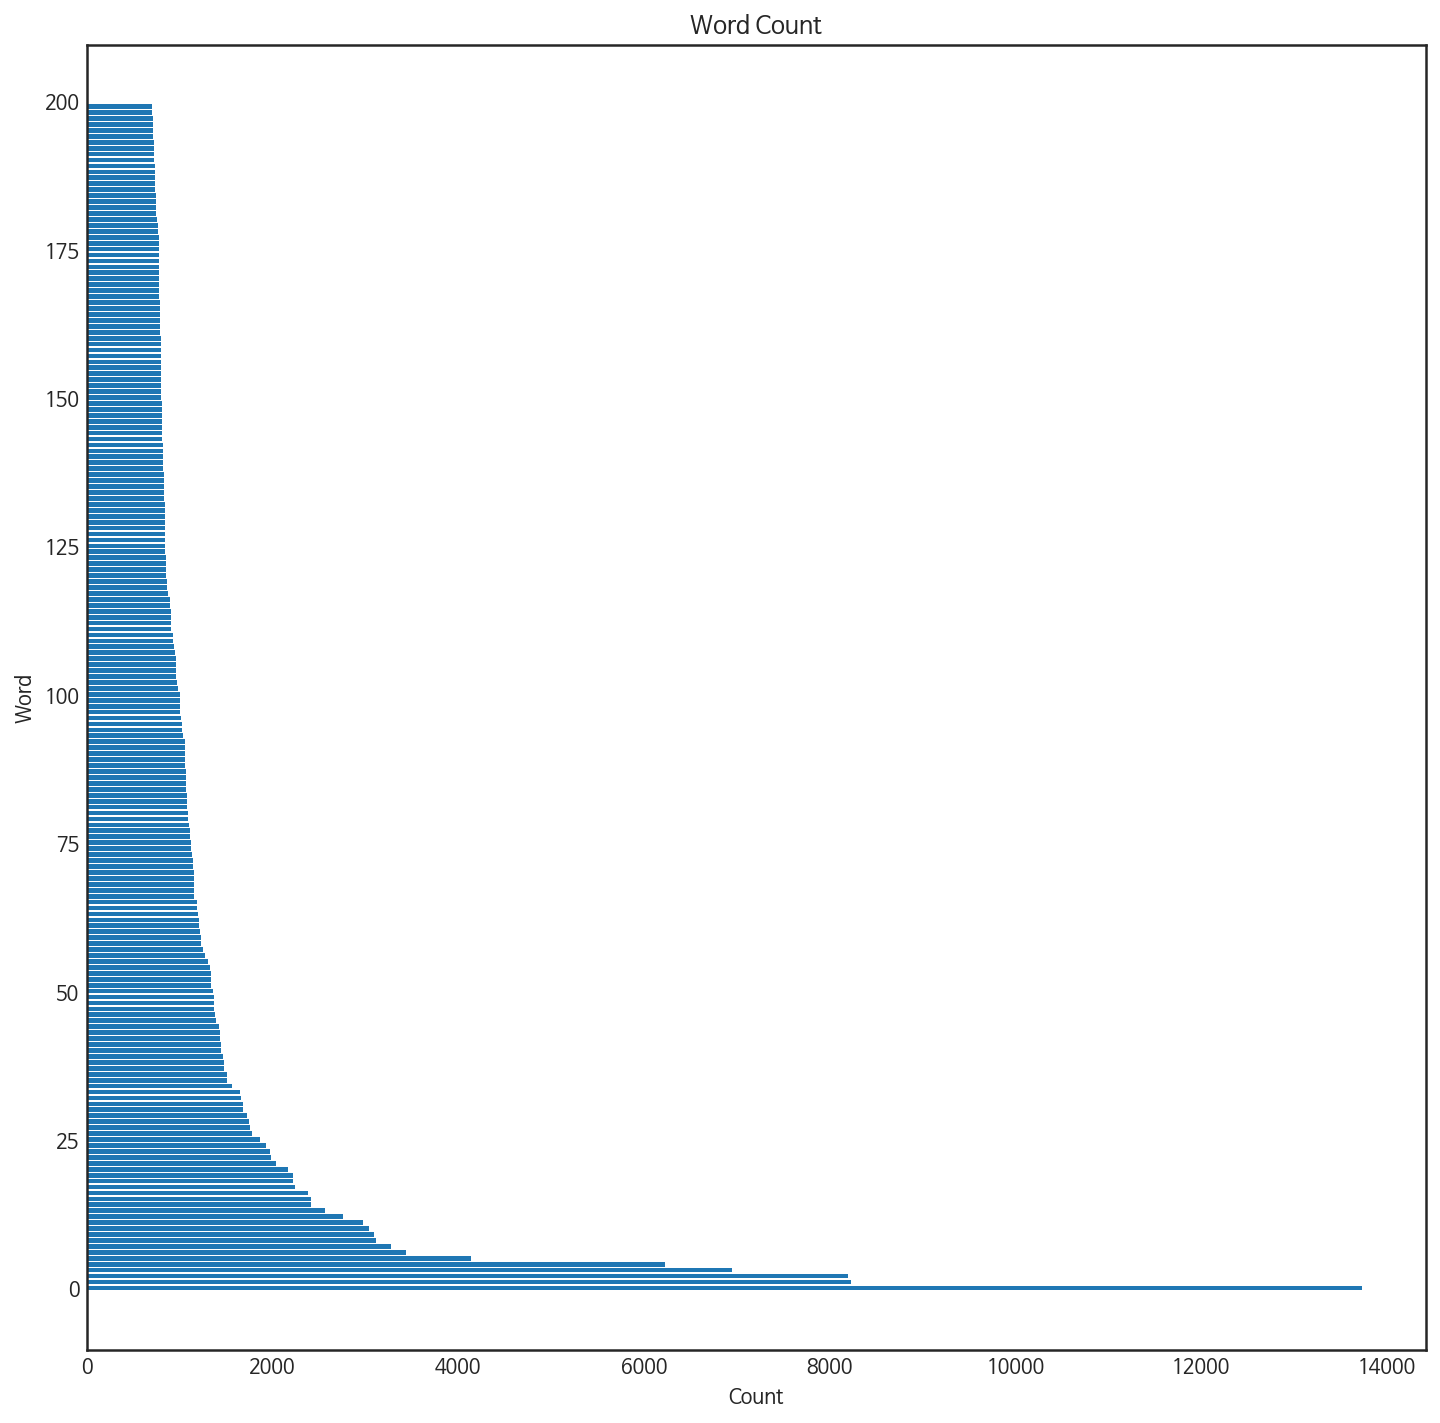

In [29]:
# top 200
word_freq_dic = dict(zip(word_freq['단어'][:200].tolist(), word_freq['빈도수'][:200].tolist()))

y_pos = np.arange(len(word_freq_dic))

plt.figure(figsize=(12,12))
plt.barh(y_pos, word_freq_dic.values())
plt.title('Word Count')
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

### 워드크라우드

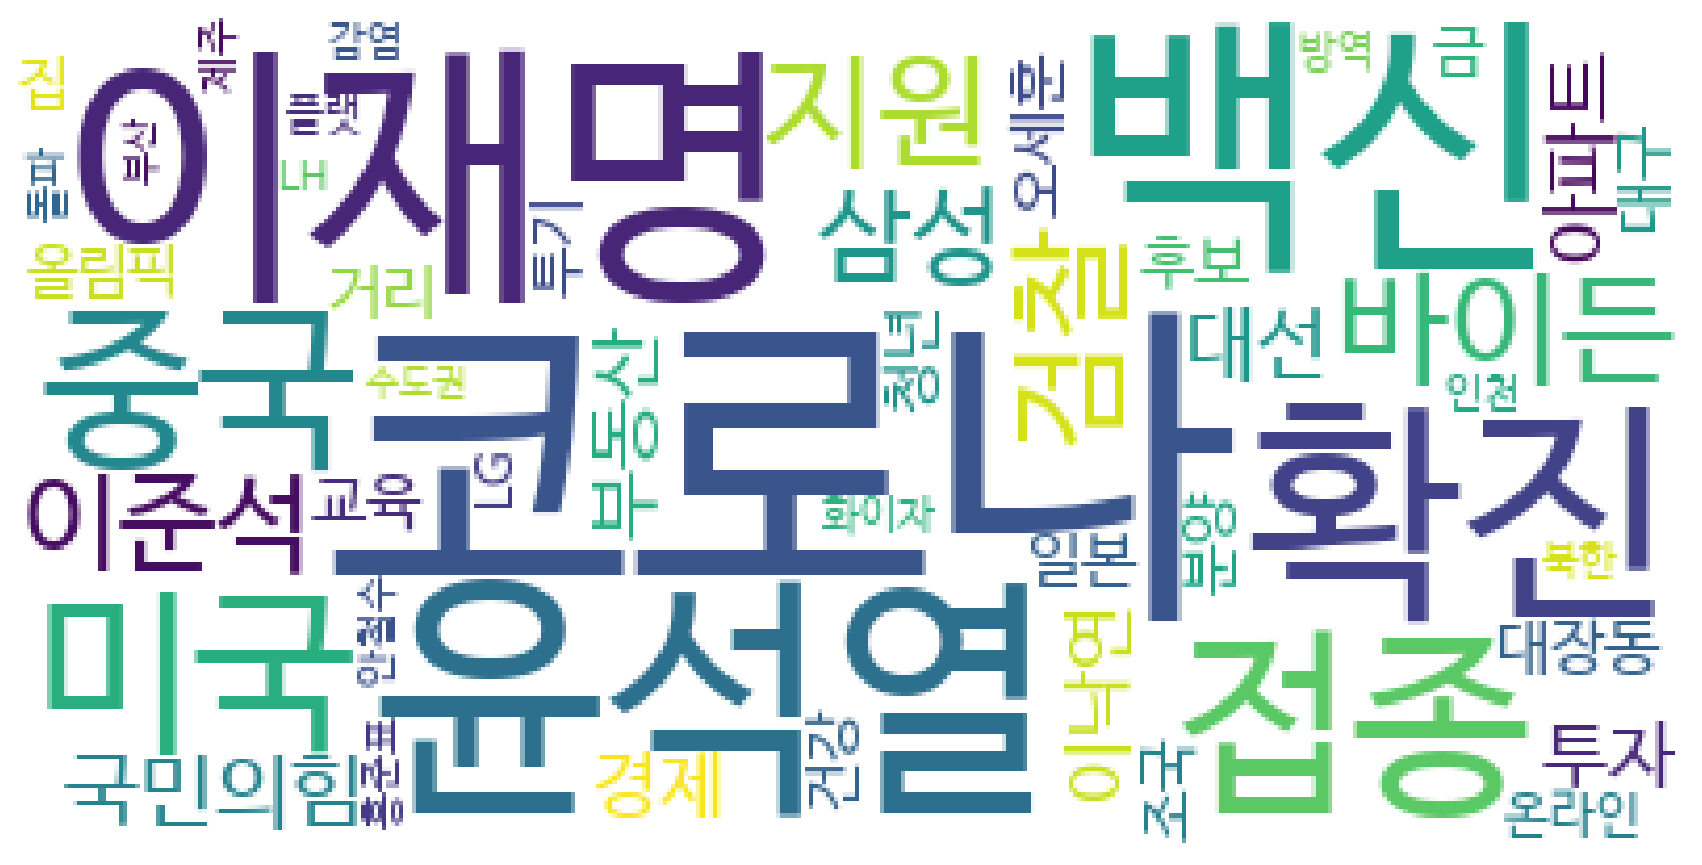

In [30]:
# top 50
word_freq_dic = dict(zip(word_freq['단어'][:50].tolist(), word_freq['빈도수'][:50].tolist()))

wc = WordCloud(background_color='white', font_path='/content/drive/MyDrive/3조_final_project/98_코딩파일/NanumBarunGothic.ttf')
wc.generate_from_frequencies(word_freq_dic)

figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

In [31]:
# # 저장
# cloud.to_file('word_freq_200.jpg')

## 1-2 TF-IDF

In [32]:
docs = df['제목'].tolist()

# 모델
vect = TfidfVectorizer(max_features=1000, stop_words=stop_words)
tfvect = vect.fit_transform(docs)

# 데이터 프레임
word_tf = pd.DataFrame({
    '단어': vect.get_feature_names(),
    'TF-IDF': tfvect.sum(axis=0).flat
})

# TF-IDF에 따라 내림차순
word_tf.sort_values('TF-IDF', ascending=False, inplace=True)

# 인덱스 
word_tf.reset_index(drop=True, inplace=True)

In [33]:
for i in range(1,13) :
  docs = globals()['df_{}'.format(i)]['제목'].tolist()

  # 모델
  tfvect = vect.fit_transform(docs)

  # 데이터 프레임으로
  globals()['word_tf_{}'.format(i)] = pd.DataFrame(data=[vect.get_feature_names(), tfvect.sum(axis=0).flat])
  globals()['word_tf_{}'.format(i)] = globals()['word_tf_{}'.format(i)].T

  # 컬럼명 변경
  globals()['word_tf_{}'.format(i)].columns = ['{}월 명사'.format(i), '{}월 TF-IDF'.format(i)]

  # TF-IDF에 따라 내림차순
  globals()['word_tf_{}'.format(i)].sort_values(by='{}월 TF-IDF'.format(i), ascending=False, inplace=True)

  # 인덱스 
  globals()['word_tf_{}'.format(i)].reset_index(drop=True, inplace=True)

In [34]:
# 전체
word_tf[:300]

,단어,TF-IDF
0,코로나,6653.052967
1,이재명,4088.545777
2,백신,3879.157693
3,윤석열,3390.885137
4,확진,2126.916784
5,접종,1827.221234
6,이준석,1725.643575
7,바이든,1699.625587
8,국민의힘,1574.864538
9,확진자,1568.603889


In [35]:
# 월별 top 20
word_tf_month = pd.DataFrame()
for i in range(1,13):
  word_tf_month = pd.concat([word_tf_month, globals()['word_tf_{}'.format(i)]], axis=1)

In [36]:
word_tf_month.iloc[:20,::2]

,1월 명사,2월 명사,3월 명사,4월 명사,5월 명사,6월 명사,7월 명사,8월 명사,9월 명사,10월 명사,11월 명사,12월 명사
0,코로나,코로나,코로나,코로나,코로나,코로나,코로나,코로나,코로나,이재명,이재명,이재명
1,백신,백신,lh,백신,백신,윤석열,윤석열,아프간,이재명,대장동,코로나,코로나
2,바이든,접종,백신,오세훈,접종,이준석,이재명,백신,윤석열,코로나,윤석열,윤석열
3,트럼프,확진,투기,접종,바이든,백신,백신,이재명,추석,윤석열,요소수,오미크론
4,확진,바이든,윤석열,민주당,부동산,접종,확진,윤석열,대장동,백신,이준석,확진
5,확진자,지원,오세훈,부동산,이준석,조국,올림픽,탈레반,백신,홍준표,대장동,이준석
6,박범계,김명수,박영선,바이든,김오수,대선,확진자,올림픽,이낙연,유동규,대선,김건희
7,정인이,학폭,접종,확진,지원,부동산,이준석,확진,확진,노태우,전두환,백신
8,이낙연,미얀마,부동산,국민의힘,미국,아파트,최재형,이준석,홍준표,검찰,백신,박근혜
9,새해,확진자,안철수,아파트,이재명,이재명,이낙연,언론중재법,국민의힘,국민의힘,확진,지원


## 1-3 토픽 모델링 (Topic Modeling)
- 토픽 모델링: 문서 집합에서 주제를 찾아내기 위한 기술

### 평가기준 (Measure)
1. Coherence (일관성) \
해당 토픽 모델의 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

  - 주의사항! \
  문서 집합의 Coherence 가 높아지면 monotonic 해지는 문제점이 생김. 마치 Bias-Variance tradeoff 처럼, 만약 coherence가 너무 높아지면 정보의 양이 줄어들게 되고, coherence가 너무 낮아지면 정보들이 일관성이 없어짐.

2. Perplexity (혼란도) \
Perlexity값이 작으면 토픽모델이 문서를 잘 반영된다고 할 수 있음. 그러나 Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님


* Recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. Optimizing for perplexity may not yield human interpretable topics. This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence. The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. \
 출처: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


In [70]:
texts = np.array(df['noun'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus[1])

[(10, 1), (11, 1), (12, 1), (13, 1)]


### LSA
- 잠재 의미 분석(Latent Semantic Analysis) = 잠재 의미 인덱싱(Latent Semantic Indexing, LSI)
* 잠재 의미 분석(LSA)은 주로 문서 색인의 의미 검색에 사용
* LSA의 목표는 문서와 단어의 기반이 되는 잠재적인 토픽을 발견하는 것
* 잠재적인 토픽은 문서에 있는 단어들의 분포를 주도한다고 가정

* BoW에 기반한 DTM이나 TF-IDF는 기본적으로 단어의 빈도 수를 이용한 수치화 방법이기 때문에 단어의 의미를 고려하지 못한다는 단점이 있음

* LSA는 쉽고 빠르게 구현이 가능할 뿐만 아니라 단어의 잠재적인 의미를 이끌어낼 수 있어 문서의 유사도 계산 등에서 좋은 성능을 보여준다는 장점을 갖고 있음. 하지만 SVD의 특성상 이미 계산된 LSA에 새로운 데이터를 추가하여 계산하려고 하면 보통 처음부터 다시 계산해야 함. 즉, 새로운 정보에 대해 업데이트가 어려움. 이는 최근 LSA 대신 Word2Vec 등 단어의 의미를 벡터화할 수 있는 또 다른 방법론인 인공 신경망 기반의 방법론이 각광받는 이유임.

In [71]:
lsi_model = LsiModel(corpus, num_topics=14, id2word=dictionary)
topics = lsi_model.print_topics()
topics

[(0,
  '0.907*"코로나" + 0.275*"확진" + 0.263*"백신" + 0.114*"접종" + 0.037*"감염" + 0.034*"신규확진" + 0.034*"위드" + 0.027*"화이자" + 0.027*"치료" + 0.025*"확산"'),
 (1,
  '0.848*"백신" + 0.384*"접종" + -0.277*"코로나" + 0.112*"이재명" + -0.105*"확진" + 0.094*"화이자" + 0.069*"윤석열" + 0.043*"모더나" + 0.035*"미국" + 0.034*"예약"'),
 (2,
  '0.793*"이재명" + 0.526*"윤석열" + 0.136*"이낙연" + -0.126*"백신" + 0.081*"대장동" + 0.067*"이준석" + 0.066*"대선" + 0.062*"홍준표" + 0.060*"국민의힘" + -0.060*"접종"'),
 (3,
  '0.803*"윤석열" + -0.546*"이재명" + 0.103*"이준석" + -0.095*"이낙연" + 0.070*"홍준표" + 0.070*"검찰" + 0.059*"국민의힘" + -0.057*"대장동" + 0.048*"김종인" + 0.045*"대선"'),
 (4,
  '0.936*"확진" + -0.298*"코로나" + 0.073*"감염" + 0.051*"오미크론" + 0.047*"접종" + 0.045*"거리" + 0.041*"거리두기" + 0.033*"집단감염" + 0.031*"수도권" + 0.029*"돌파"'),
 (5,
  '0.651*"중국" + 0.577*"미국" + 0.331*"바이든" + 0.086*"지원" + 0.084*"아프간" + 0.078*"경제" + 0.077*"일본" + 0.074*"삼성" + 0.072*"투자" + -0.071*"접종"'),
 (6,
  '0.362*"이준석" + 0.358*"지원" + 0.344*"대장동" + 0.305*"국민의힘" + 0.292*"검찰" + 0.204*"오세훈" + 0.194*"부동산" + 0.193*"투기" + 0.1

### LDA

- 잠재 디리클레 할당(Latent Dirichlet Allocation)
* 잠재 디레클레 할당 방법
  1. 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 w가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

  * $p(t|d)$ - 문서 d의 단어들 중 토픽 t에 해당하는 비율  

  * $p(w|t)$- 단어 w를 가지고 있는 모든 문서들 중  토픽 t가 할당된 비율

* LDA는 문서들은 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정. 데이터가 주어지면, LDA는 문서가 생성되던 과정을 역추적.

- LSA : DTM을 차원 축소 하여 축소 차원에서 근접 단어들을 토픽으로 묶는다.
- LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.

In [72]:
# lda_model = LdaModel(corpus, num_topics=14, id2word=dictionary,          
#                      passes=1, decay=0.5, offset=1.0,                    
#                      update_every=1, alpha='symmetric', eta=None,         
#                      distributed=False, chunksize=2000,  eval_every=10, iterations=50,  
#                      gamma_threshold=0.001, minimum_probability=0.01, 
#                      random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None)

#### 최적화 (Optimization)
- LDA 공식 문서: https://radimrehurek.com/gensim/models/ldamodel.html
- LDA 설명 블로그: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/
- LDA 설명 블로그: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado

##### Topic 수 변화

In [73]:
min_topics, max_topics = 20, 50
coherences_score2=[]
perplexities_score2=[] 

for num_topics in range(min_topics, max_topics) :
  time_before = time.time()
  lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1)
  print('num_topics "{}"'.format(num_topics))
 
  cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary)

  coherences_score2.append(cm.get_coherence())
  perplexities_score2.append(lda_model.log_perplexity(corpus))

  print("Cpherence : ", cm.get_coherence())    
  print('Perplexity : ', lda_model.log_perplexity(corpus))
  print('Time : ', (time.time() - time_before)/60)
  print('='*30)

num_topics "20"
Cpherence :  0.5030758618753637
Perplexity :  -11.947674126151032
Time :  4.307411809762319
num_topics "21"
Cpherence :  0.5033717577431711
Perplexity :  -12.001833360014132
Time :  4.167288851737976
num_topics "22"
Cpherence :  0.5062976517335741
Perplexity :  -12.06273845262447
Time :  4.250175150235494
num_topics "23"
Cpherence :  0.5105965119818792
Perplexity :  -12.116505456611339
Time :  4.302829146385193
num_topics "24"
Cpherence :  0.5169989765258447
Perplexity :  -12.16210592261394
Time :  4.39931229352951
num_topics "25"
Cpherence :  0.5178516471075816
Perplexity :  -12.221972958459183
Time :  4.453193442026774
num_topics "26"
Cpherence :  0.5038660633045084
Perplexity :  -12.274762987482324
Time :  4.544821592171987
num_topics "27"
Cpherence :  0.5125470076979431
Perplexity :  -12.32303805792057
Time :  4.600605996449788
num_topics "28"
Cpherence :  0.5237358773317066
Perplexity :  -12.377771381428243
Time :  4.635245076815287
num_topics "29"
Cpherence :  0.5

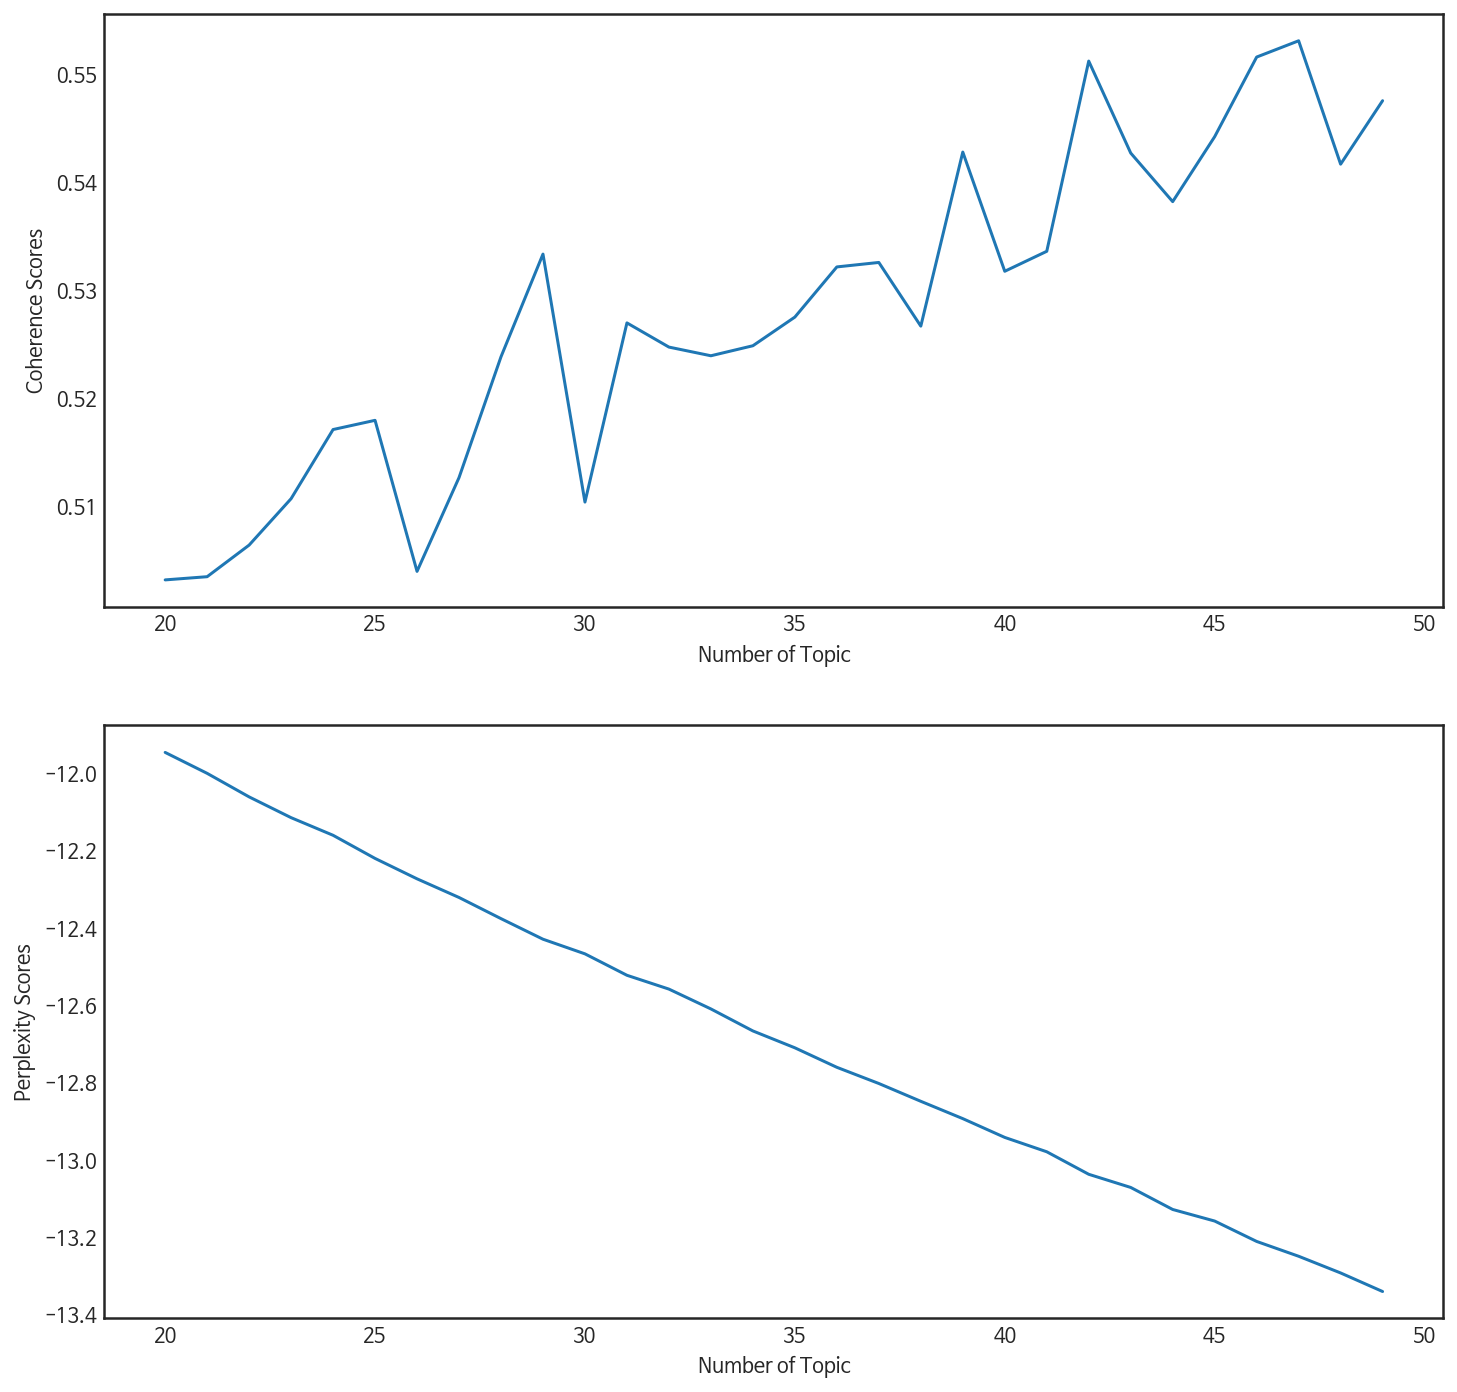

In [74]:
x = [int(i) for i in range(min_topics, max_topics)]

plt.subplot(2,1,1)
plt.plot(x, coherences_score2)
plt.xlabel('Number of Topic')
plt.ylabel('Coherence Scores')

plt.subplot(2,1,2)
plt.plot(x, perplexities_score2)
plt.xlabel('Number of Topic')
plt.ylabel('Perplexity Scores')
plt.show();

#### LDA 시각화

In [77]:
pyLDAvis.enable_notebook()
lda_model_42 = LdaModel(corpus, num_topics=42, id2word=dictionary, passes=1)

In [78]:
vis_42 = pyLDAvis.gensim.prepare(lda_model_42, corpus, dictionary)
pyLDAvis.display(vis_42)

# 2 특정 키워드 분석

In [44]:
keyword = '이준석'
keywords = ['이재명','윤석열','이낙연','홍준표']
# keywords = list(input().split(' '))

## 2-1 사회 연결망 분석 (Social Network Analysis)

### 동시 출현 단어

#### Bigram

In [45]:
bgrams = [bigrams(x) for x in df['noun'].tolist()]

token = []
for idx, i in enumerate(bgrams) :
  try : 
    token += ([x for x in i])
  except :   # 공백 리스트 예외 처리
    pass
    # print(f'{idx} : {list(i)}')
# token

cfd = ConditionalFreqDist(token)
# cfd.conditions()

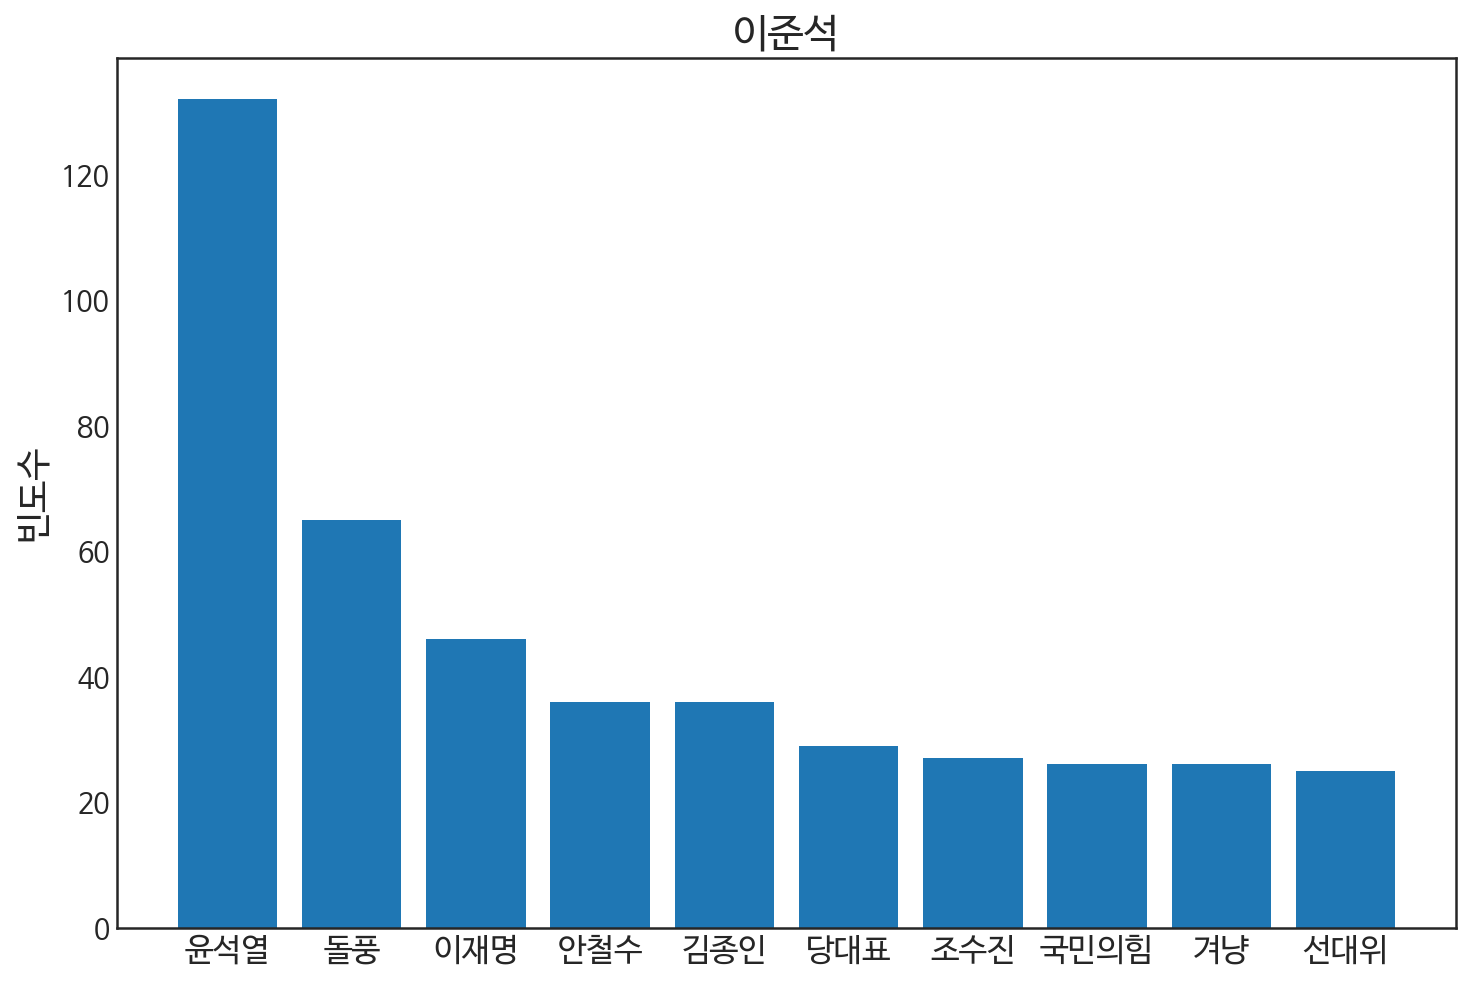

In [46]:
plt.figure(figsize=(12,8))
x = [i[0] for i in cfd[keyword].most_common(10)]
y = [i[1] for i in cfd[keyword].most_common(10)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('빈도수', fontsize=18)
plt.show()

In [47]:
# keyword = '공개'
print(cfd[keyword].most_common(10))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   print(idx, keyword, cfd[keyword].most_common(10))

[('윤석열', 132), ('돌풍', 65), ('이재명', 46), ('안철수', 36), ('김종인', 36), ('당대표', 29), ('조수진', 27), ('국민의힘', 26), ('겨냥', 26), ('선대위', 25)]


#### Trigram

In [48]:
# trigram
tgrams = [ngrams(x,3) for x in df['noun'].tolist()]
ttoken = []

for idx, i in enumerate(tgrams) :
  try : 
    ttoken += ([x for x in i])
  except :
    pass
#     print(f'{idx} : {list(i)}')
# ttoken

condition_pairs = ((w0, (w1, w2)) for w0, w1, w2 in ttoken)
cfd_trigrams = ConditionalFreqDist(condition_pairs)

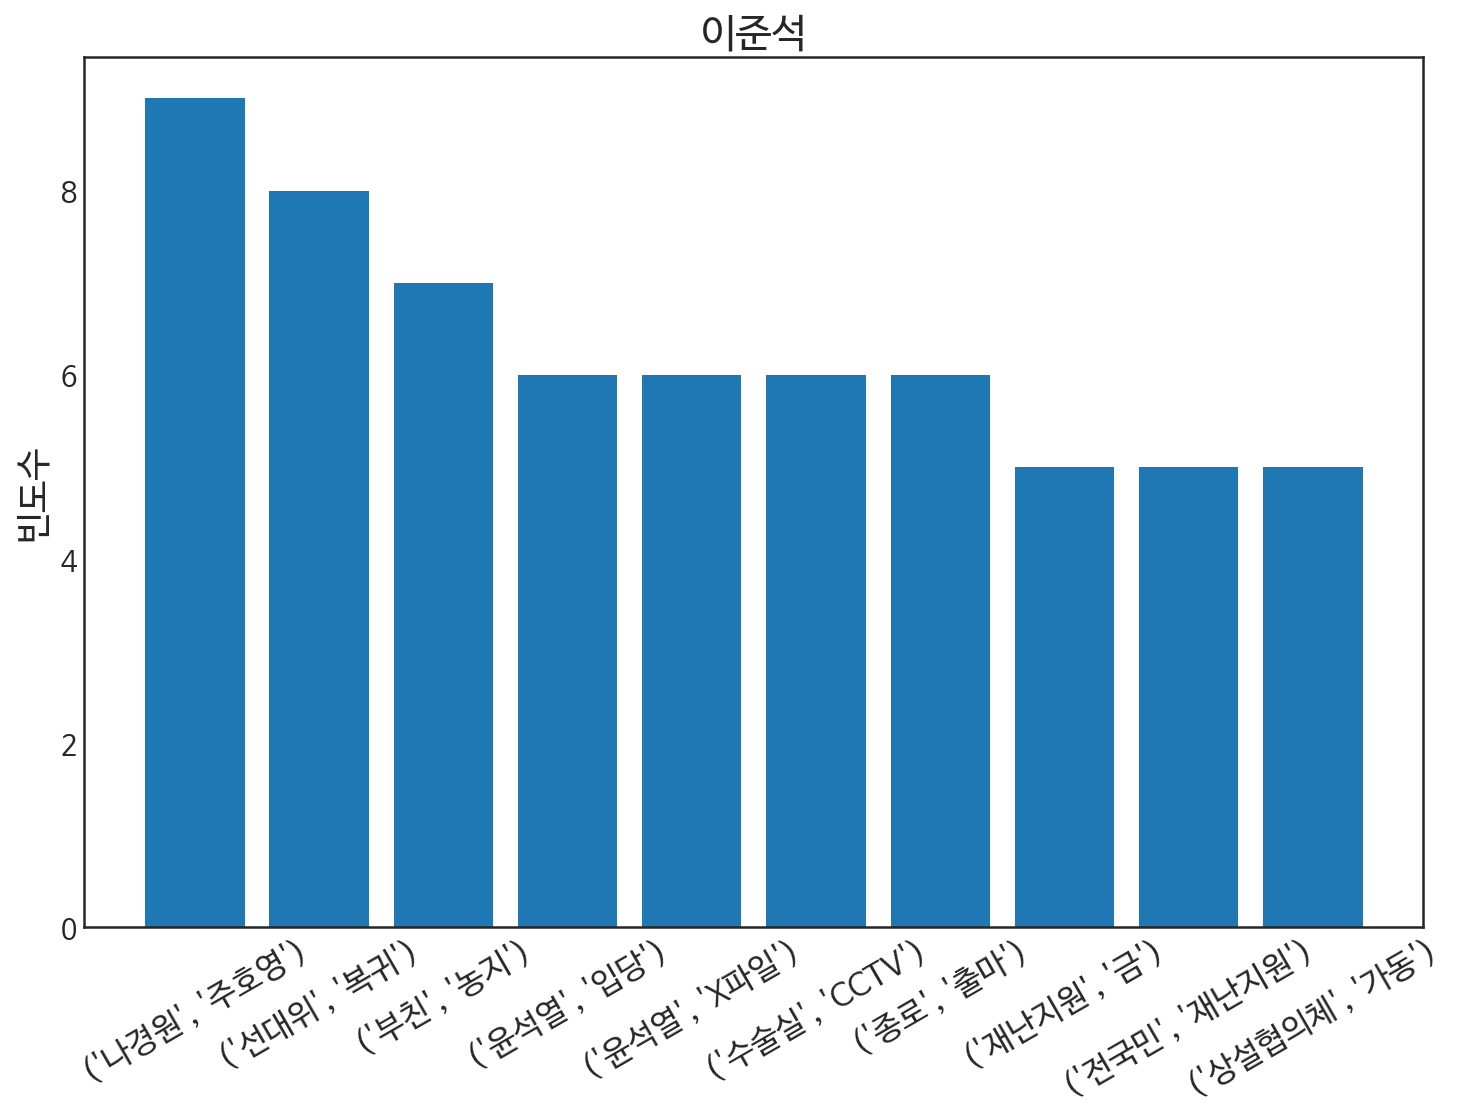

In [49]:
plt.figure(figsize=(12,8))
x = [str(i[0]) for i in cfd_trigrams[keyword].most_common(10)]
y = [i[1] for i in cfd_trigrams[keyword].most_common(10)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=14)
plt.ylabel('빈도수', fontsize=18)
plt.show()

In [50]:
# keyword = '공개'
print(cfd_trigrams[keyword].most_common(10))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   print(idx, keyword, cfd_trigrams[keyword].most_common(10))

[(('나경원', '주호영'), 9), (('선대위', '복귀'), 8), (('부친', '농지'), 7), (('윤석열', '입당'), 6), (('윤석열', 'X파일'), 6), (('수술실', 'CCTV'), 6), (('종로', '출마'), 6), (('재난지원', '금'), 5), (('전국민', '재난지원'), 5), (('상설협의체', '가동'), 5)]



### 단어 유사도 (Word2Vec)
- https://radimrehurek.com/gensim/models/word2vec.html
- https://hoonzi-text.tistory.com/2

In [51]:
w2v = Word2Vec(sentences=df['noun'].tolist(), size=200, window=5, min_count=4, workers=4, sg=0)
# workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

# w2v.wv.vocab.keys()
w2v.wv.vectors.shape

(49222, 200)

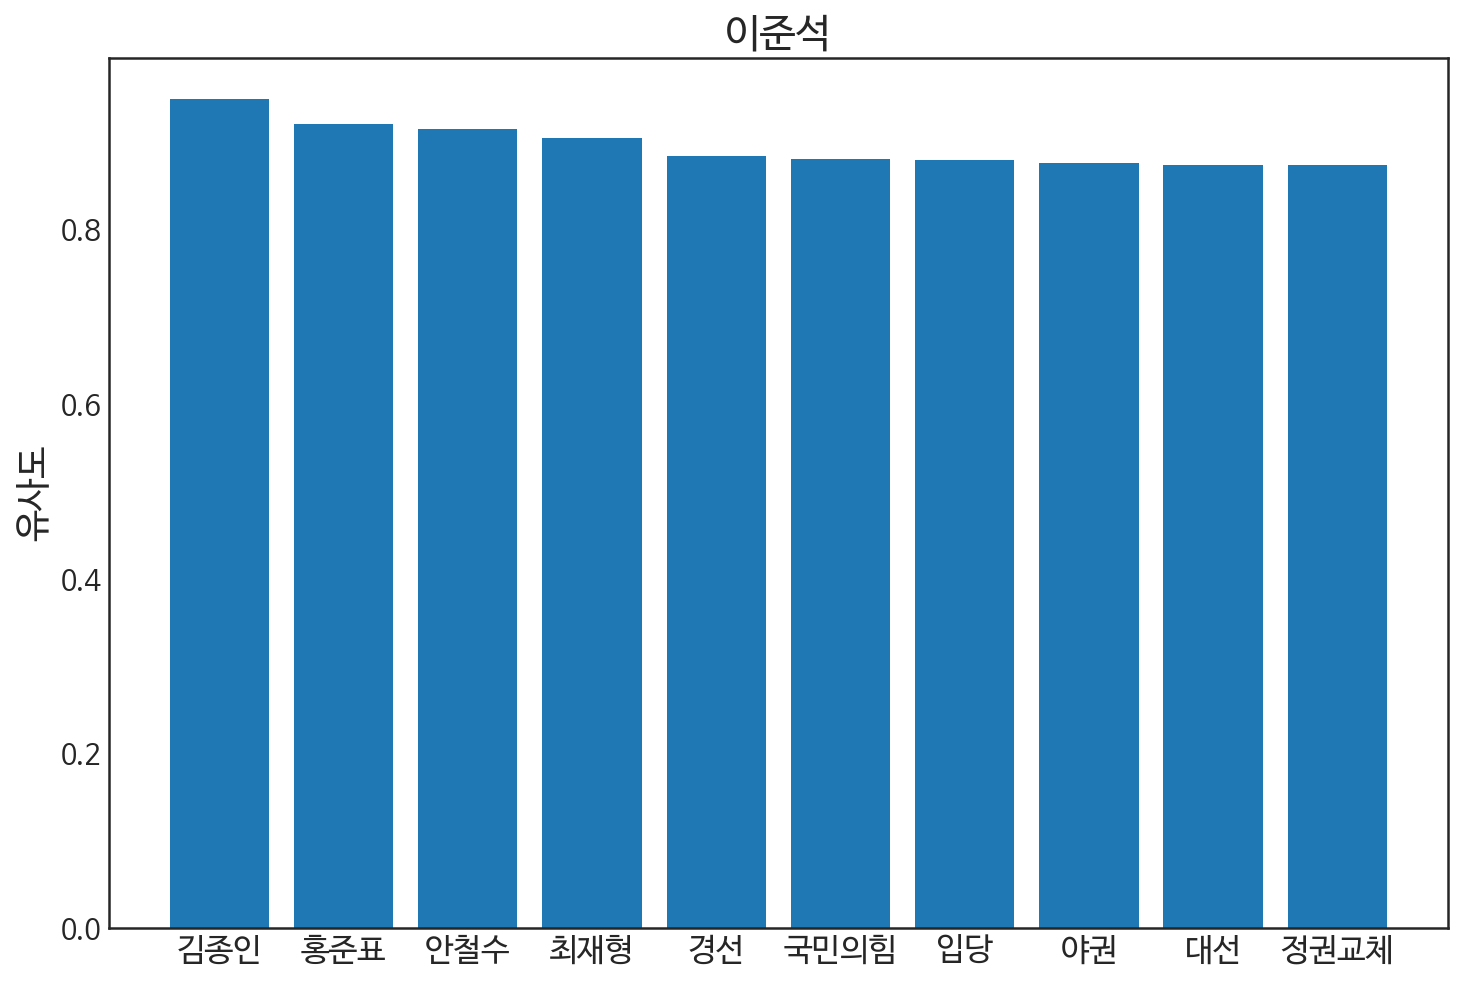

In [52]:
plt.figure(figsize=(12,8))
x = [i[0] for i in w2v.wv.most_similar(keyword)]
y = [i[1] for i in w2v.wv.most_similar(keyword)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('유사도', fontsize=18)
plt.show()

In [53]:
# keyword = '공개'
print(w2v.wv.most_similar(keyword, topn=20))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   try : print(idx, keyword, w2v.wv.most_similar(keyword, topn=20))
#   except : print(idx, keyword, '없음')

[('김종인', 0.948974609375), ('홍준표', 0.9208639860153198), ('안철수', 0.9148094654083252), ('최재형', 0.9040255546569824), ('경선', 0.8837296962738037), ('국민의힘', 0.8801909685134888), ('입당', 0.8788619041442871), ('야권', 0.8755360841751099), ('대선', 0.873694658279419), ('정권교체', 0.8734005689620972), ('선대위', 0.8674834370613098), ('투표', 0.8664736747741699), ('단일화', 0.8662729263305664), ('김동연', 0.8620685338973999), ('당대표', 0.860529899597168), ('합당', 0.8547976613044739), ('당권', 0.8464670181274414), ('후보들', 0.8461076021194458), ('여론', 0.8454324007034302), ('대권', 0.8450480699539185)]


#### 시각화
- https://projector.tensorflow.org/

In [79]:
# from gensim.models import KeyedVectors  
# w2v.wv.save_word2vec_format('w2v')   # 모델 저장

In [55]:
# !python -m gensim.scripts.word2vec2tensor --input w2v --output w2v   # 쥬피터에서 실행

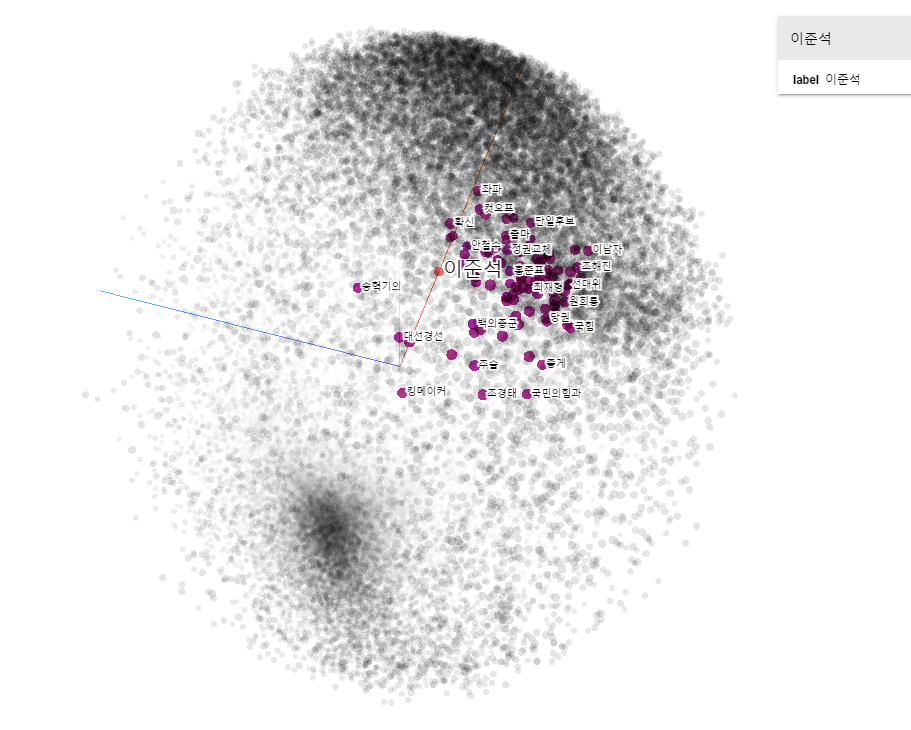

In [80]:
Image('/content/drive/MyDrive/3조_final_project/01_뉴스 기사/EmbeddingProjector_이준석.png')

## 2-2 시계열 분석 (Time Series Analysis)

In [57]:
# 전체
df_time = df[['일자','noun']]
df_time['count'] = df_time['noun'].apply(lambda x : 1 if keyword in x else 0)
df_time = df_time.groupby('일자').sum()
df_time['ratio'] = df_time['count'] / df_time['count'].sum() *100

In [58]:
# 언론사별
print(df['언론사'].unique())

for i in df['언론사'].unique() :
  a = df[df['언론사'] == i]
  a = a[['일자','noun']]
  a['count'] = a['noun'].apply(lambda x : 1 if keyword in x else 0)
  a = a.groupby('일자').sum()
  a['ratio'] = a['count'] / a['count'].sum() *100

  globals()['df_time_{}'.format(i)] = a

['경향신문' '동아일보' '조선일보' '중앙일보' '한겨레']


### 빈도수 시각화

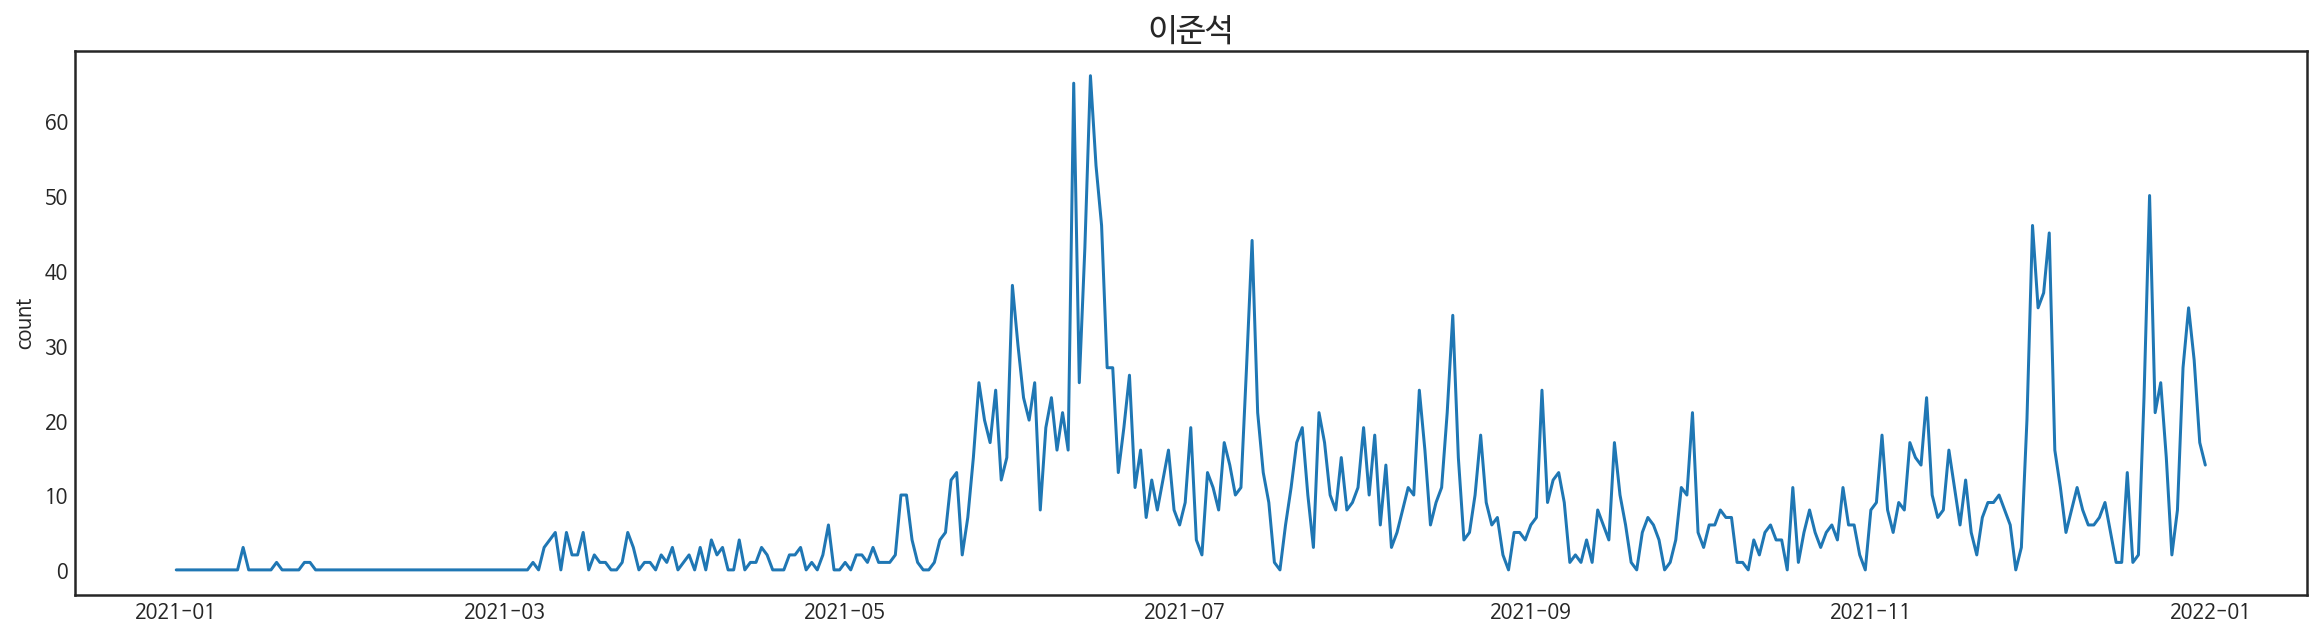

In [59]:
fig = plt.figure(figsize=(20,5))
plt.plot(df_time['count'])
plt.title(keyword, fontsize=16)
plt.ylabel('count')
plt.show()

### 분해 시계열

In [60]:
# 시계열 분해 (전체)
decompostion = sm.tsa.seasonal_decompose(df_time['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

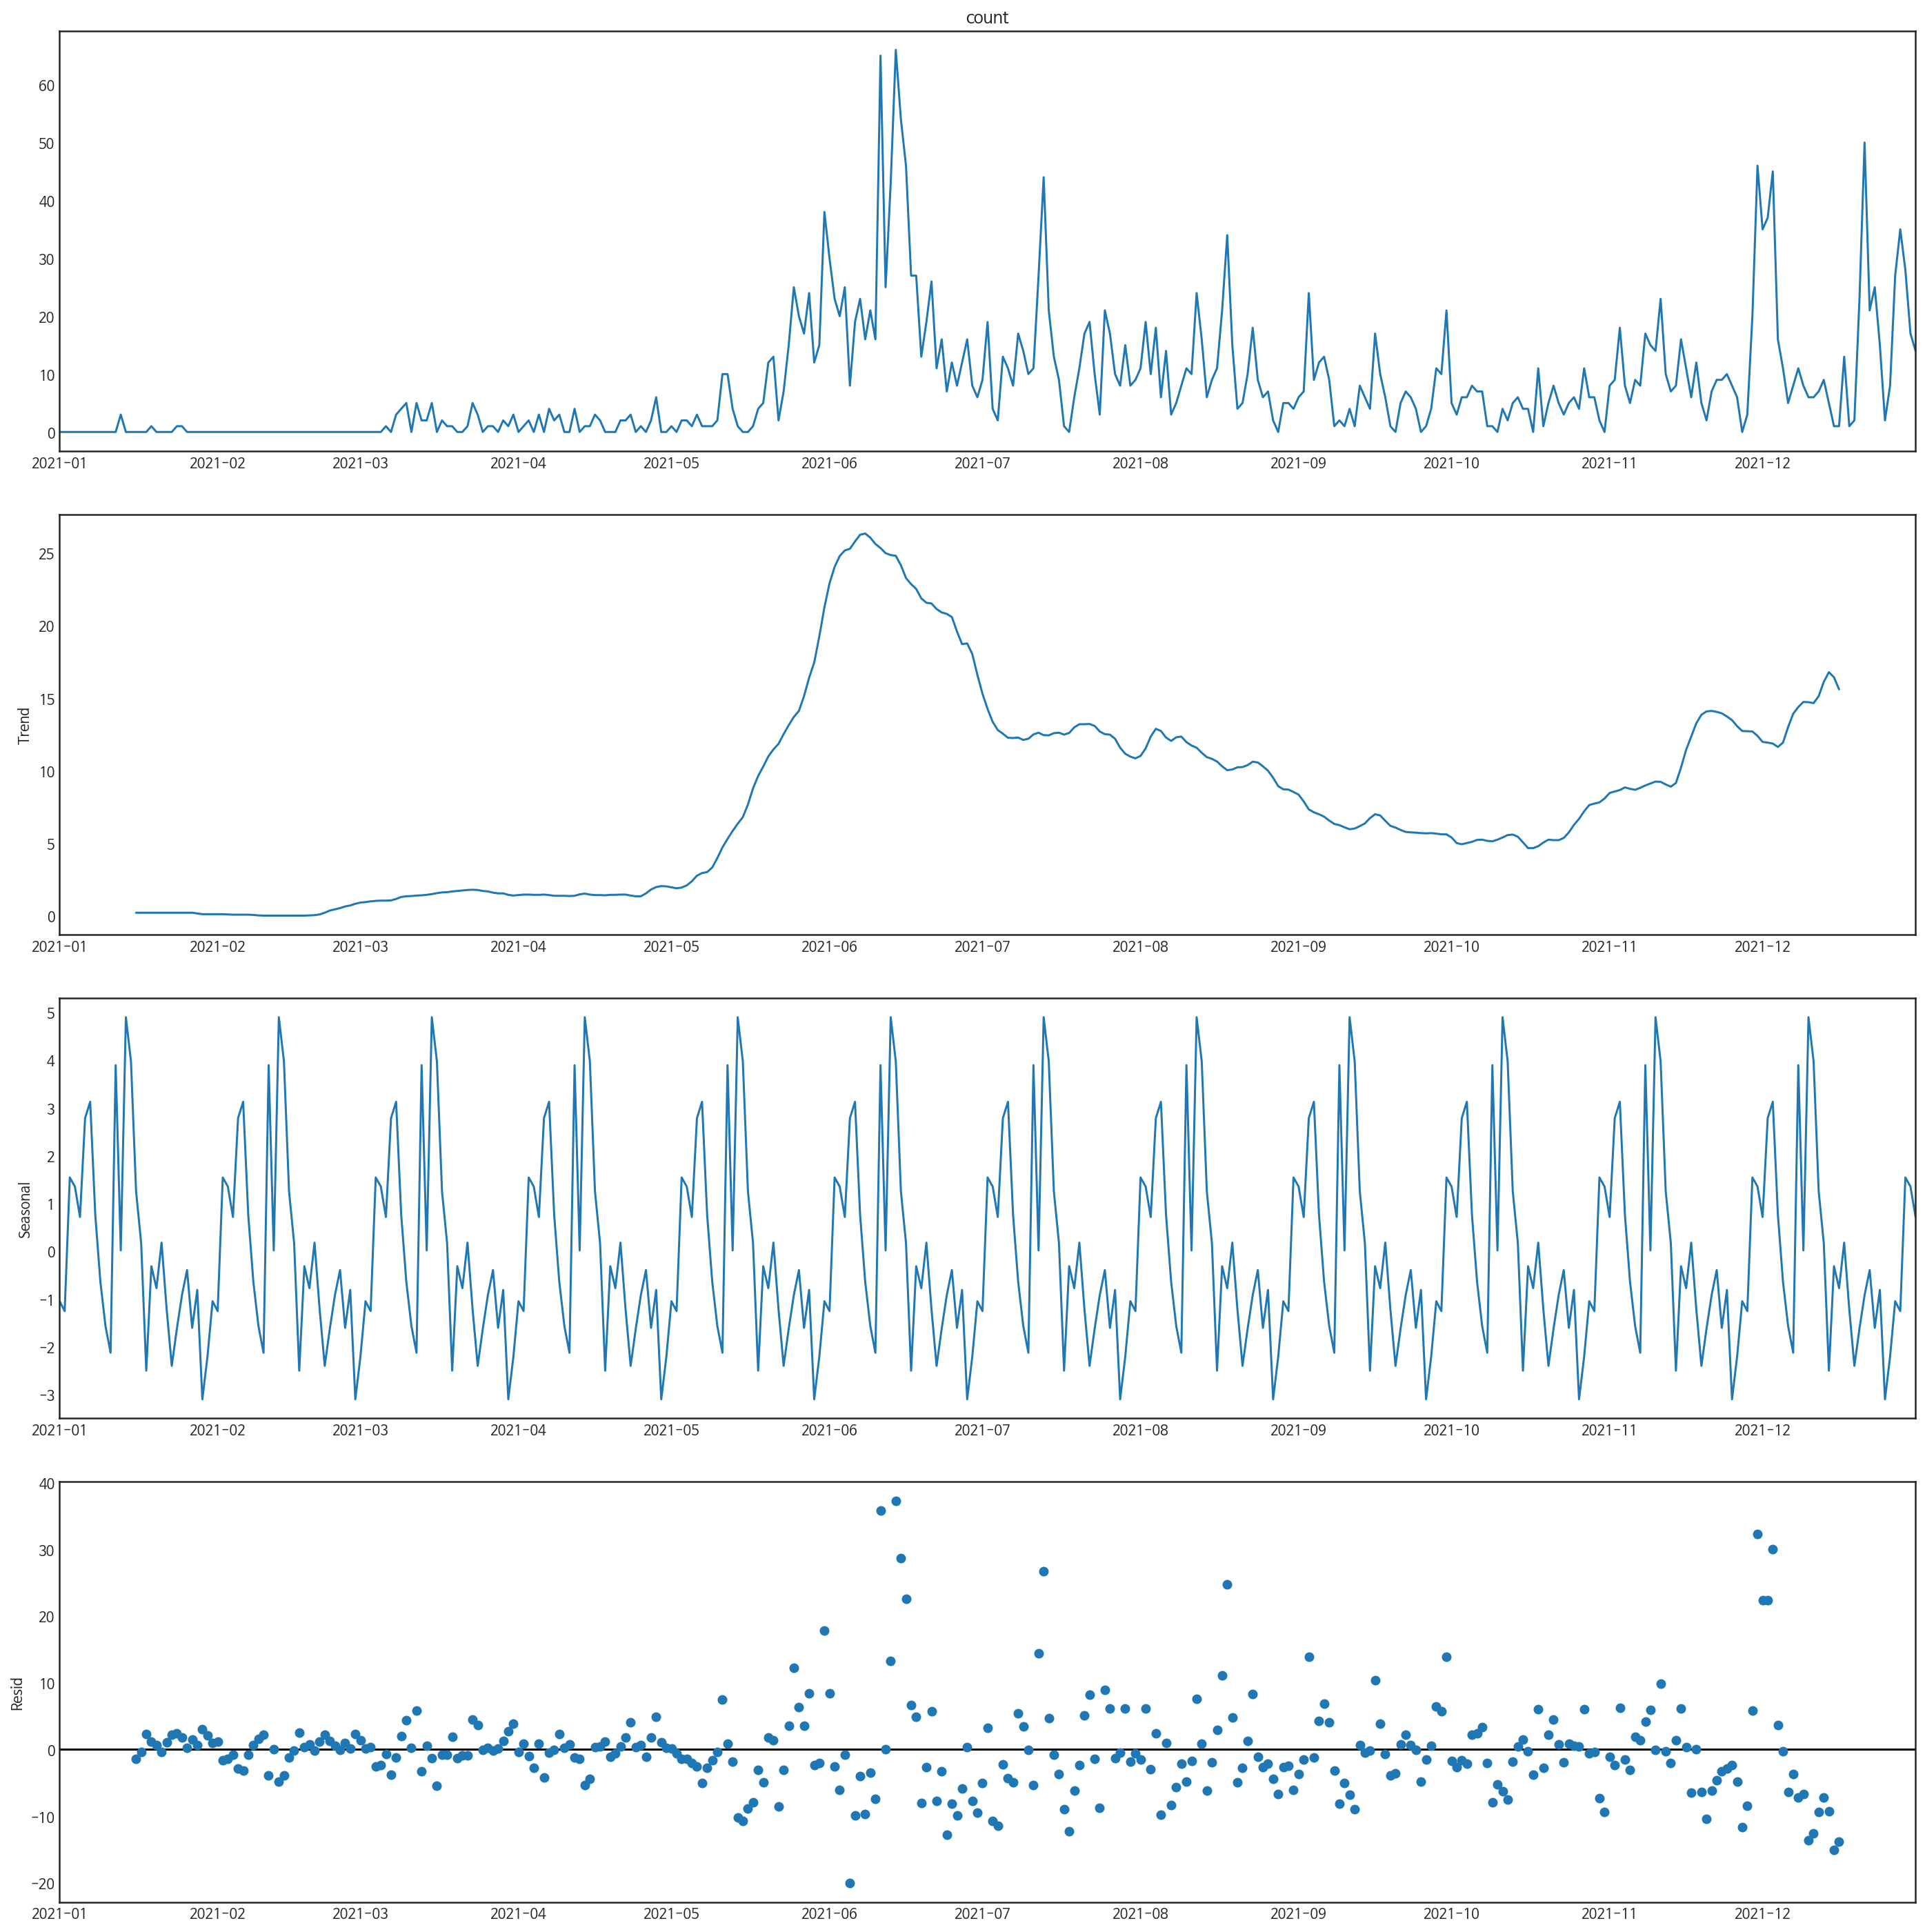

In [61]:
fig = decompostion.plot()
fig.set_size_inches(20,20)
plt.show()

### 언론사별 keyword trend 분석
- 비율로 비교

In [62]:
# 시계열 분해 (전체)
decompostion = sm.tsa.seasonal_decompose(df_time['ratio'], model='additive', period=30)   # model{“additive”, “multiplicative”}

# 시계열 분해 (언론사별)
for i in df['언론사'].unique() :
  globals()['decompostion_{}'.format(i)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(i)]['ratio'], model='additive', period=30)

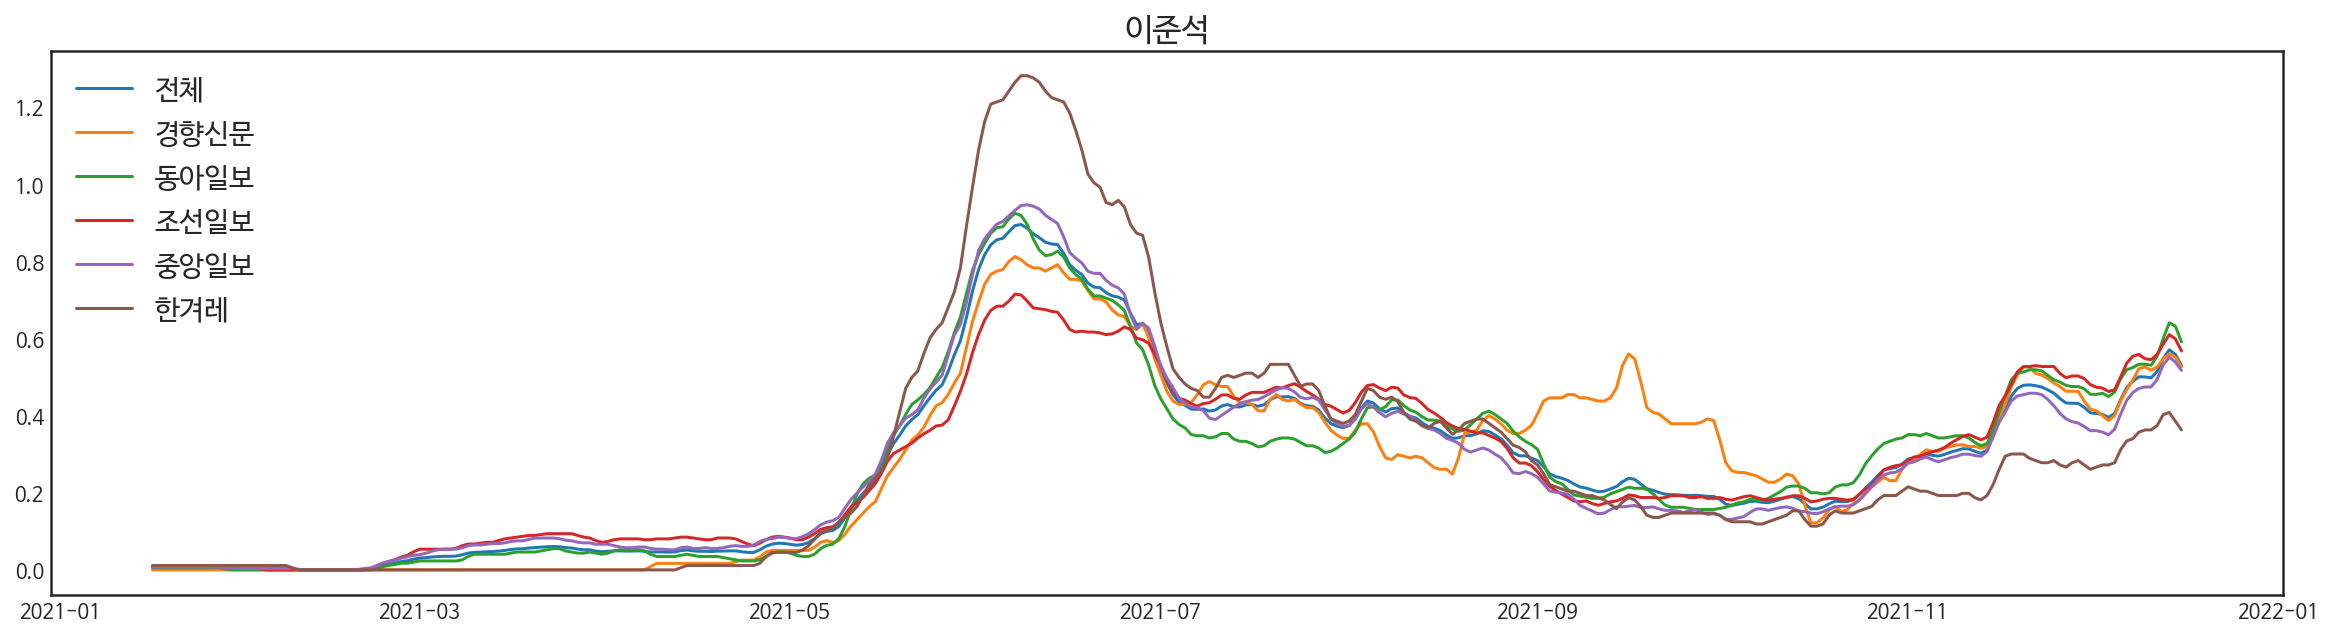

In [63]:
fig = plt.figure(figsize=(20,5))
plt.plot(decompostion.trend, label='전체')
for i in df['언론사'].unique() :
  plt.plot(globals()['decompostion_{}'.format(i)].trend, label=i)
plt.title(keyword, fontsize=16)
plt.legend(fontsize=14)
plt.show()

### 비교 분석

In [64]:
# keywords = list(input().split(' '))

for keyword in keywords :
  globals()['df_time_{}'.format(keyword)] = df[['일자','noun']]
  globals()['df_time_{}'.format(keyword)]['count'] = globals()['df_time_{}'.format(keyword)]['noun'].apply(lambda x : 1 if keyword in x else 0)
  globals()['df_time_{}'.format(keyword)] = globals()['df_time_{}'.format(keyword)].groupby('일자').sum()
  globals()['df_time_{}'.format(keyword)]['ratio'] = globals()['df_time_{}'.format(keyword)]['count'] / globals()['df_time_{}'.format(keyword)]['count'].sum() *100

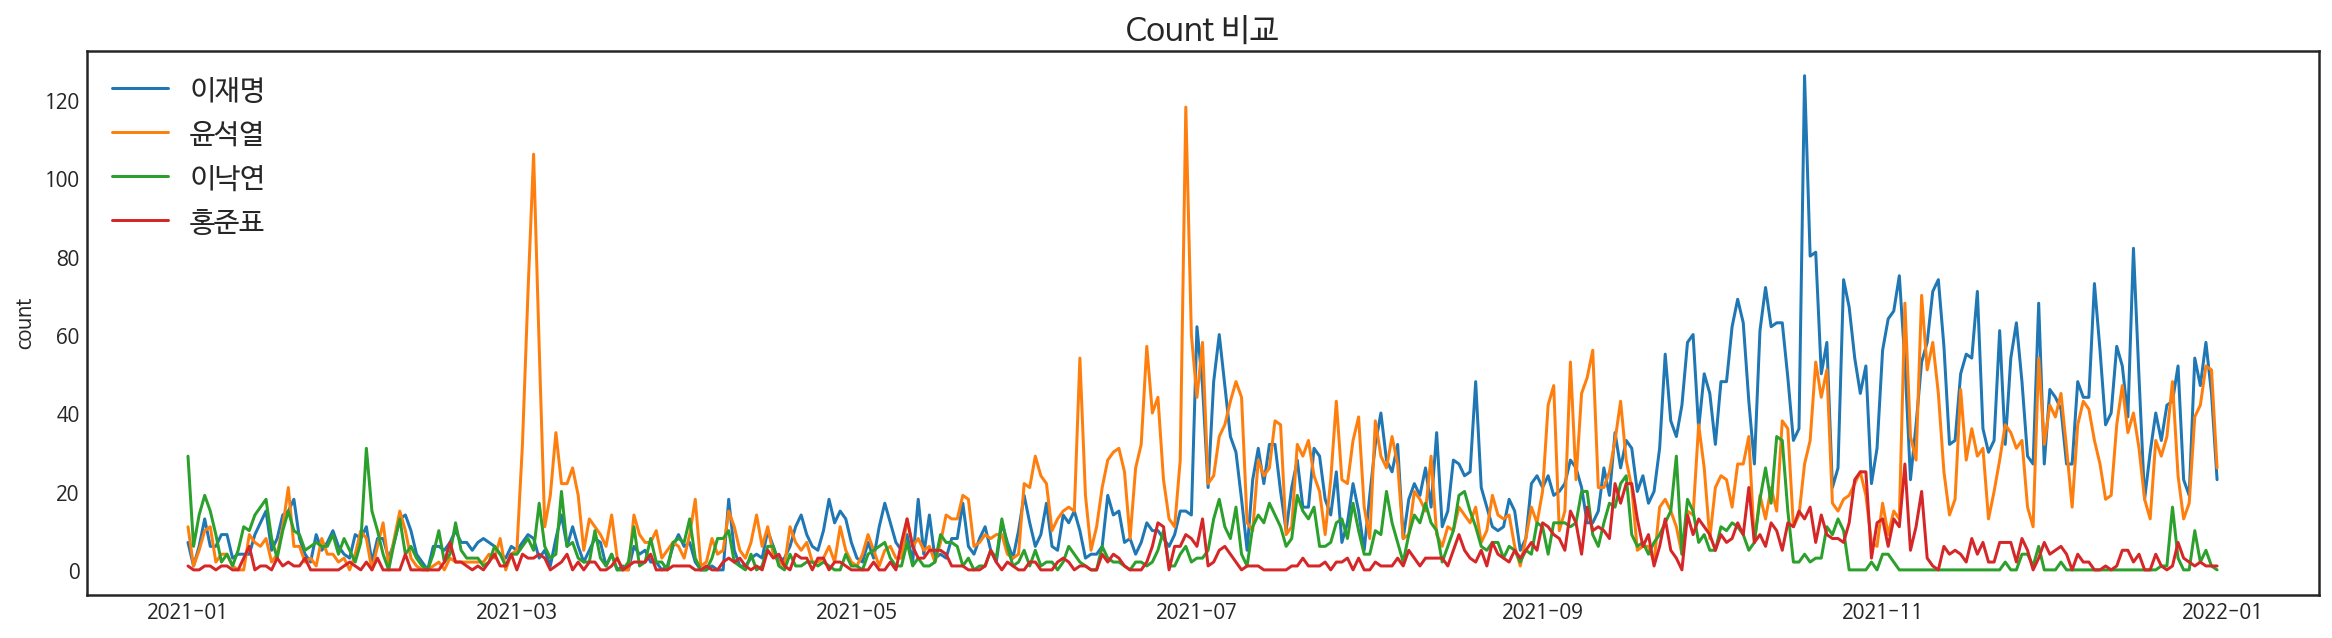

In [65]:
fig = plt.figure(figsize=(20,5))
for keyword in keywords :
  plt.plot(globals()['df_time_{}'.format(keyword)]['count'], label=keyword)
  plt.title('Count 비교', fontsize=16)
  plt.legend(fontsize=14)
  plt.ylabel('count')
plt.show()

In [66]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

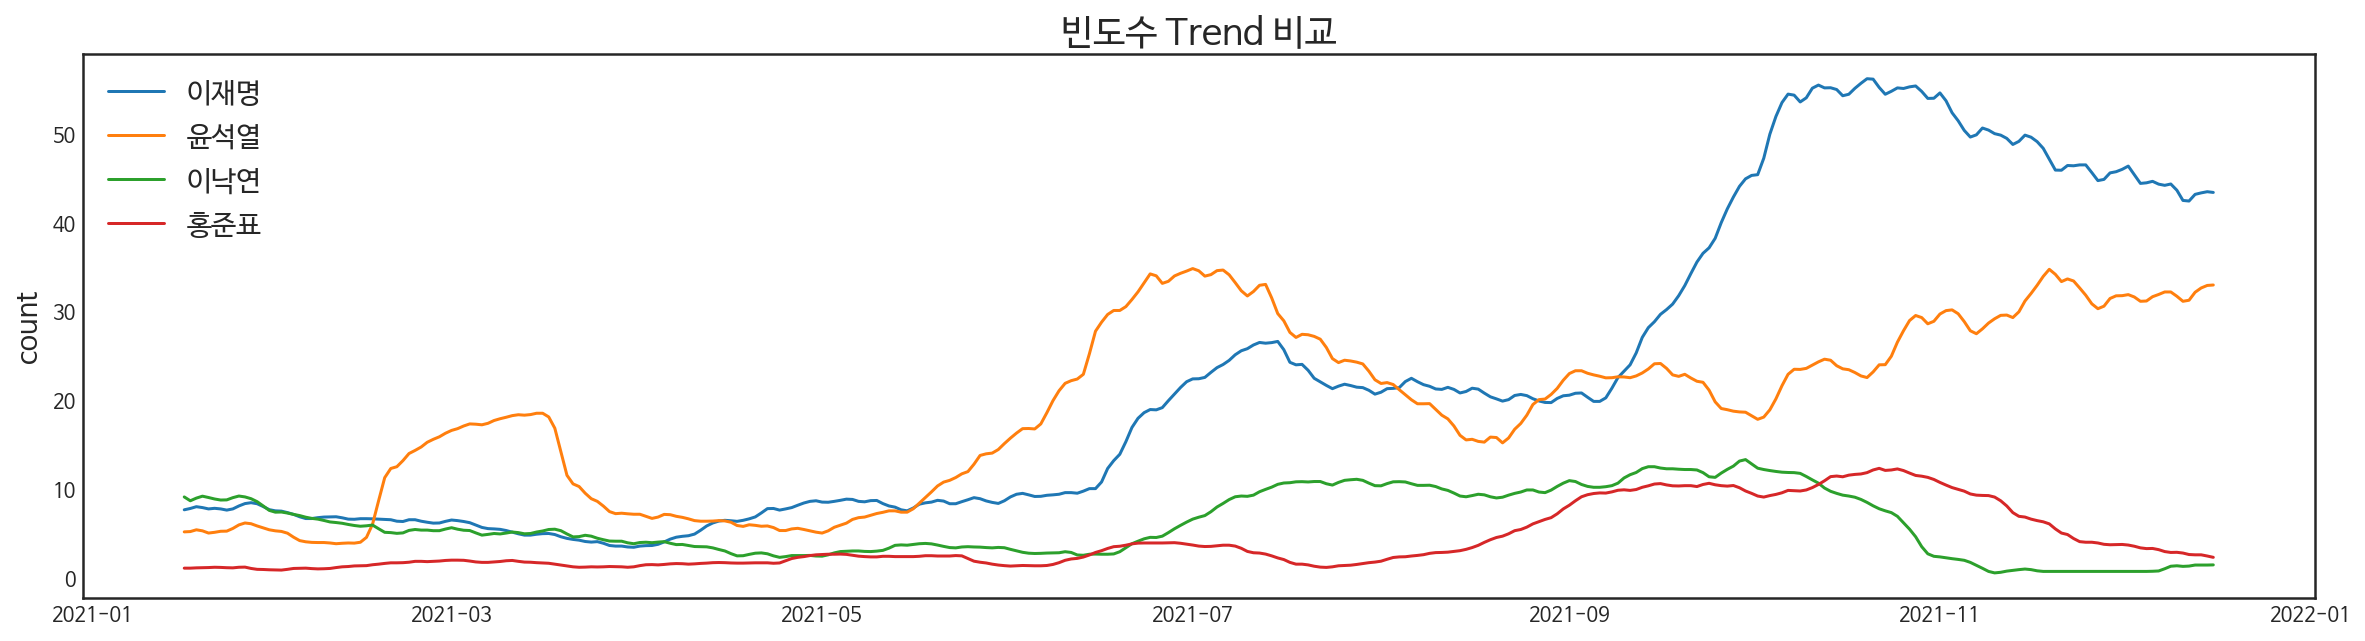

In [67]:
fig = plt.figure(figsize=(20,5))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('빈도수 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('count', fontsize=14)
plt.show()

In [68]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['ratio'], model='additive', period=30)   # model{“additive”, “multiplicative”}

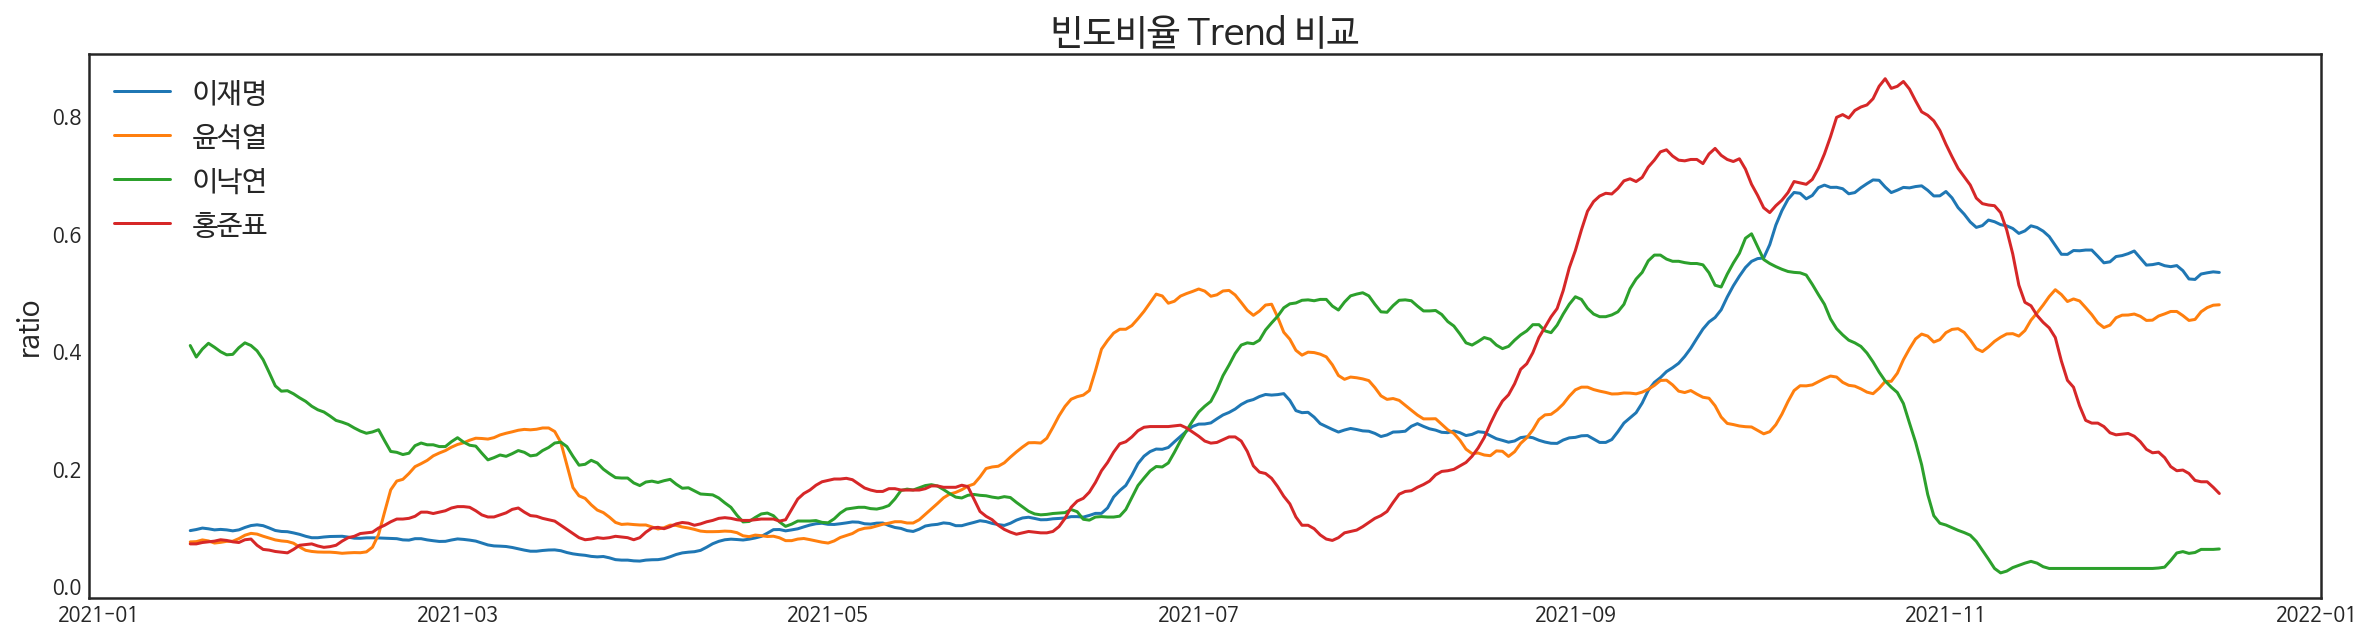

In [69]:
fig = plt.figure(figsize=(20,5))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('빈도비율 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('ratio', fontsize=14)
plt.show()